In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784',version=1) #imprt the mnist dataset from sciki-tlearn
mnist.keys() #Shows the important attributes of the dataset

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'] , mnist['target']
X.shape # (70000,784(28x28 pixels))
y.shape
X.head(5)


NameError: name 'mnist' is not defined

In [1]:
#fetch the first row of pixel values to display the number
some_digit = X.values[0] # OR some_digit = X.head(1).values[0]
some_digit_image = some_digit.reshape(28, 28) #reshape into 28 x 28 pixels
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

NameError: name 'X' is not defined

In [5]:
y.values[0] # gives "5" as string
y = y.astype(np.uint8) #convert to integer 
y.values[0] 


5

In [6]:
#The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):
X_train, X_test, y_train, y_test = X[:60000] , X[60000:] , y[:60000] , y[60000:]

In [7]:
#try to identify one digit—for example,the number 5
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier #SGDClassifier relies on randomness during training
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
sgd_clf.predict([some_digit])

In [9]:
#Implementing cross-validation using StratifiedKFold
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
# for train_index, test_index in skfolds.split(X_train,y_train_5):
#     # print(train_index,test_index)
#     clone_clf = clone(sgd_clf) 
#     X_train_folds = X_train[train_index]
#     y_train_folds = y_train_5[train_index]
#     X_test_fold = X_train[test_index]
#     y_test_fold = y_train_5[test_index]

#     clone_clf.fit(X_train_folds,y_train_folds)
#     y_pred = clone_clf.prediction(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct/len(y_pred))



In [10]:
#Implementing cross-validation using cross_val_score function from model_selection
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [11]:
# Confusion Matrix : A much better way to evaluate the performance of a classifier is to look at the confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [12]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions) # pretend we reached perfection

array([[54579,     0],
       [    0,  5421]])

In [13]:
# Precision and recall_score
from sklearn.metrics import precision_score , recall_score 
print(precision_score(y_train_5, y_train_pred))
recall_score(y_train_5, y_train_pred)


0.8370879772350012


0.6511713705958311

In [14]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [15]:
# Precision/Recall Trade-off
y_scores = sgd_clf.decision_function([some_digit]) #decision score
threshold = 8000 # OR 0
# y_scores
y_some_digit_pred = (y_scores > threshold) #raising the threshold decreases recall
y_some_digit_pred


/home/helloworld/ml/Handwritten_digits_classification/global_env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

In [ ]:
"""How do you decide which threshold to use? First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions"""
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

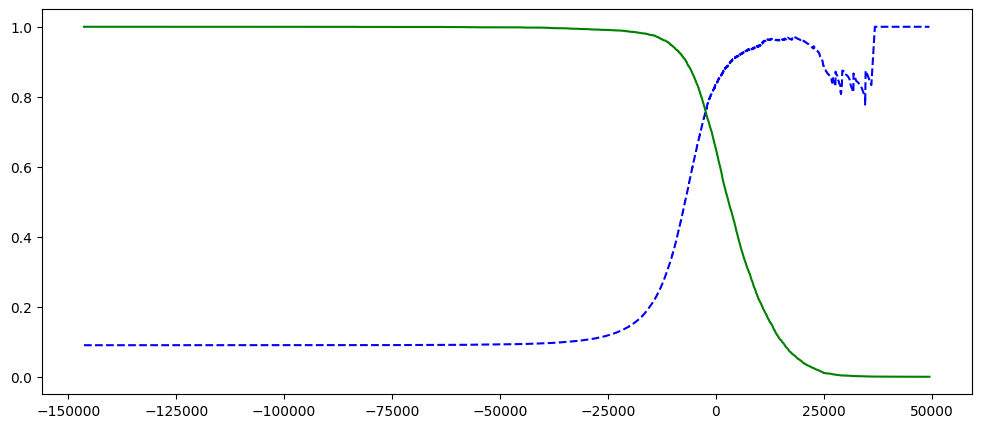

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
# Precision versus recall
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] #returns the indices of the maximum values along an axis
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

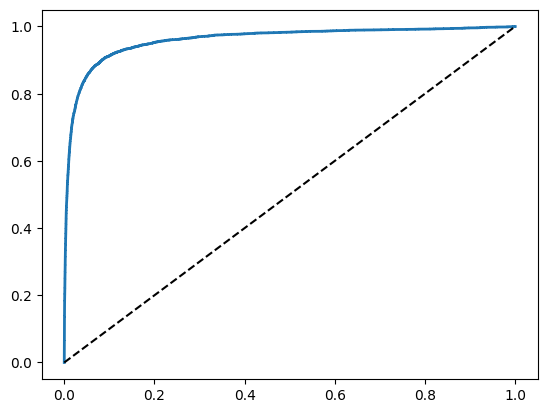

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr, tpr, label=None): #ROC curve plots the false positive rate against the true positive rate for all possible thresholds
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr,tpr)
plt.show()

In [20]:
"""One way to compare classifiers is to measure the area under the curve (AUC). """
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

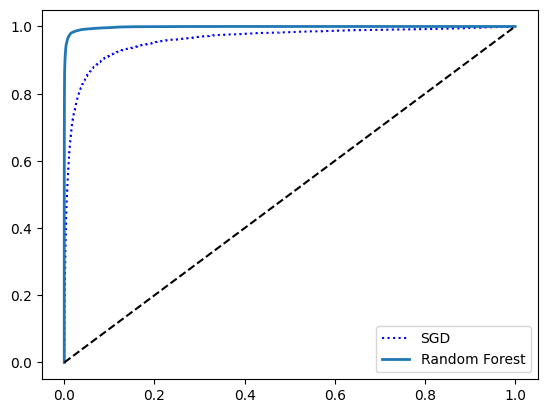

In [21]:
#train a RandomForestClassifier and compare its ROC curve and ROC AUC score
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [44]:
precision_forest = precision_score(y_train_5, (y_scores_forest > 0.5))
recall_forest = recall_score(y_train_5, (y_scores_forest > 0.5))
print(precision_forest)
print(recall_forest)

0.9905083315756169
0.8662608374838591


<h2><b>Multiclass Classification</b></h2>

In [46]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

/home/helloworld/ml/Handwritten_digits_classification/global_env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit])
# some_digit_scores #highest core is of class 5 = 9.3 (approx)
np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]


/home/helloworld/ml/Handwritten_digits_classification/global_env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


9

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you
can use the OneVsOneClassifier or OneVsRestClassifier classe

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can
directly classify instances into multiple classes. The decision_function() method
now returns one value per class

In [ ]:
sgd_clf.decision_function([some_digit])
"""output : array([[-15955.22628, -38080.96296, -13326.66695, 573.52692, -17680.68466,
2412.53175, -25526.86498, -12290.15705, -7946.05205, -10631.35889]])"""

Use the cross_val_score() function to evaluate the SGDClassifier’s accuracy

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

Simply scaling the inputs increases accuracy above 89%:

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
# array([0.89707059, 0.8960948 , 0.90693604])

array([0.8983, 0.891 , 0.9018])

<h2><b>Error Analysis</b></h2>

look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function

In [55]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

using Matplotlib’s matshow() function

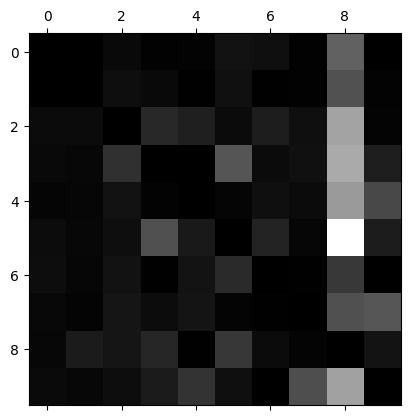

In [57]:
# plt.matshow(conf_mx,cmap=plt.cm.gray)
# plt.show()

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#Fill the diagonal with zeros to keep only the errors, and plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

let’s plot examples of 3s and 5s (the plot_digits() function just uses
Matplotlib’s imshow() function

In [ ]:
# cl_a, cl_b = 3, 5
# X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # y_train = 3 and y_train_pred = 3
# X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # y_train = 3 and y_train_pred = 5
# X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # y_train = 5 and y_train_pred = 3
# X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # y_train = 5 and y_train_pred = 5

# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# plt.show()

<h2><b>Multilabel Classification</b></h2>
classification system that outputs multiple binary tags is
called a multilabel classification system

In [58]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7) # First indicates whether or not the digit is large (7, 8, or 9)
y_train_odd = (y_train % 2 == 1) # indicates whether or not the digit is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])
# The digit 5 is indeed not large (False) and odd (True).

/home/helloworld/ml/Handwritten_digits_classification/global_env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [59]:
# computes the average F1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

<h2><b>Multioutput Classification</b></h2>
It is simply a generalization of multilabel classification where each label can be multiclass

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

# knn_clf.fit(X_train_mod, y_train_mod)
# clean_digit = knn_clf.predict([X_test_mod[some_index]])
# plot_digit(clean_digit)


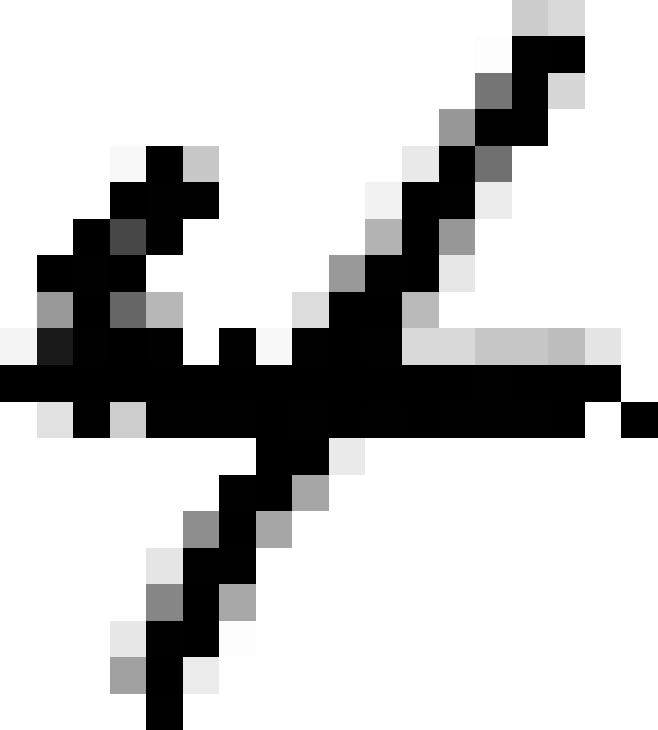